
# Attention Head Analysis — Results & Sanity Checks

This notebook helps you:
- load relation probe results (`out/*_relations.json`),
- rank heads per relation,
- inspect distributions and simple visualizations,
- run **sanity checks** and **baselines** (random target, previous-token),
- optionally open an attention dump (`out/*_attn.pkl`) to visualize single heads.


In [60]:

# Comments are in English.
import os, json, pickle, math, random
import numpy as np
import matplotlib.pyplot as plt

# ==== Configure your paths here ====
REL_JSON = "out/rifel_relations.json"   # e.g., out/en_relations.json for English
ATTN_PKL = "out/rifel_gsd_attn.pkl"     # optional, only needed for heatmaps / extra checks

print("REL_JSON:", REL_JSON)
print("ATTN_PKL:", ATTN_PKL, "(exists:", os.path.exists(ATTN_PKL), ")")

# Load relation probe results
with open(REL_JSON, "r", encoding="utf-8") as f:
    rel_res = json.load(f)

L = rel_res["layers"]
H = rel_res["heads"]
print(f"Model has {L} layers × {H} heads")

relations = list(rel_res["relations"].keys())
print("Relations present:", relations)


REL_JSON: out/rifel_relations.json
ATTN_PKL: out/rifel_gsd_attn.pkl (exists: True )
Model has 12 layers × 12 heads
Relations present: ['amod', 'det', 'nsubj', 'obj', 'case', 'advmod', 'nummod', 'compound', 'obl', 'nmod', 'conj', 'cc']


## 1) Rank heads for a chosen relation

In [73]:

# Choose a relation to inspect
for rel in relations:
    REL = rel   # change to: nsubj, obj, det, case, ...

    acc = np.array(rel_res["relations"][REL]["acc_top1"])        # shape L×H
    acc_topk = np.array(rel_res["relations"][REL].get("acc_topk@3", acc))  # if present
    mass = np.array(rel_res["relations"][REL].get("avg_head_mass", acc))   # if present

    flat = acc.flatten()
    idxs = np.argsort(flat)[::-1]
    topk = min(5, len(flat))

    print("Top heads for", REL)
    for i in range(topk):
        idx = idxs[i]
        layer = int(idx // H)
        head = int(idx % H)
        print(f"{i+1:2d}. L{layer}-H{head}  acc_top1={acc[layer,head]:.3f}  acc_topk3={acc_topk[layer,head]:.3f}  mass={mass[layer,head]:.3f}")


Top heads for amod
 1. L7-H6  acc_top1=0.906  acc_topk3=0.984  mass=0.650
 2. L3-H11  acc_top1=0.894  acc_topk3=0.984  mass=0.796
 3. L4-H7  acc_top1=0.858  acc_topk3=0.984  mass=0.626
 4. L6-H7  acc_top1=0.665  acc_topk3=0.969  mass=0.532
 5. L2-H9  acc_top1=0.665  acc_topk3=0.902  mass=0.585
Top heads for det
 1. L3-H11  acc_top1=0.932  acc_topk3=0.991  mass=0.889
 2. L7-H6  acc_top1=0.906  acc_topk3=0.982  mass=0.757
 3. L4-H7  acc_top1=0.844  acc_topk3=0.999  mass=0.640
 4. L2-H10  acc_top1=0.763  acc_topk3=0.892  mass=0.762
 5. L2-H5  acc_top1=0.761  acc_topk3=0.895  mass=0.762
Top heads for nsubj
 1. L6-H9  acc_top1=0.507  acc_topk3=0.881  mass=0.349
 2. L7-H8  acc_top1=0.406  acc_topk3=0.705  mass=0.257
 3. L4-H3  acc_top1=0.365  acc_topk3=0.712  mass=0.278
 4. L4-H8  acc_top1=0.353  acc_topk3=0.637  mass=0.235
 5. L7-H10  acc_top1=0.281  acc_topk3=0.588  mass=0.199
Top heads for obj
 1. L7-H10  acc_top1=0.801  acc_topk3=0.957  mass=0.570
 2. L4-H8  acc_top1=0.484  acc_topk3=0.7

### Plot bar chart of top heads (acc_top1)

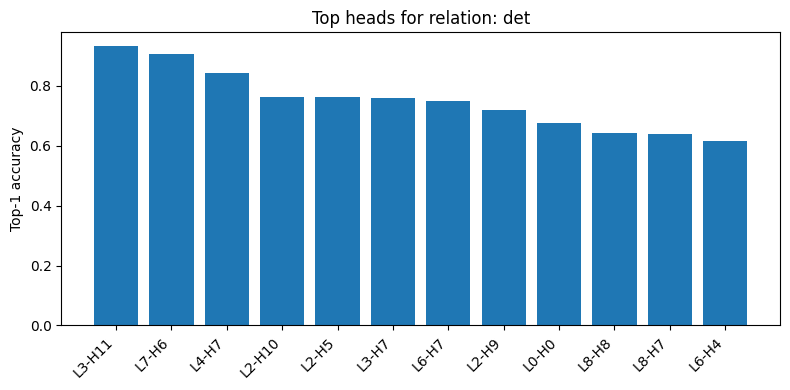

In [62]:

# Bar chart using matplotlib (single chart, no explicit colors)
top_scores = flat[idxs[:topk]]
top_labels = [f"L{int(i//H)}-H{int(i%H)}" for i in idxs[:topk]]

plt.figure(figsize=(8,4))
x = np.arange(topk)
plt.bar(x, top_scores)
plt.xticks(x, top_labels, rotation=45, ha="right")
plt.ylabel("Top-1 accuracy")
plt.title(f"Top heads for relation: {REL}")
plt.tight_layout()
plt.show()


## 2) Layer-wise summary for the relation

Layer 0: mean acc_top1 = 0.204
Layer 1: mean acc_top1 = 0.105
Layer 2: mean acc_top1 = 0.230
Layer 3: mean acc_top1 = 0.180
Layer 4: mean acc_top1 = 0.162
Layer 5: mean acc_top1 = 0.093
Layer 6: mean acc_top1 = 0.131
Layer 7: mean acc_top1 = 0.119
Layer 8: mean acc_top1 = 0.171
Layer 9: mean acc_top1 = 0.152
Layer 10: mean acc_top1 = 0.085
Layer 11: mean acc_top1 = 0.069


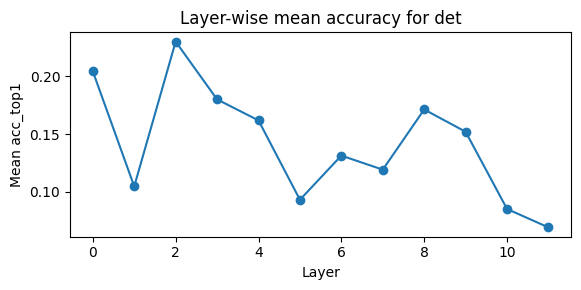

In [63]:

layer_means = acc.mean(axis=1)  # mean over heads within each layer
for l in range(L):
    print(f"Layer {l}: mean acc_top1 = {layer_means[l]:.3f}")
    
plt.figure(figsize=(6,3))
plt.plot(np.arange(L), layer_means, marker="o")
plt.xlabel("Layer")
plt.ylabel("Mean acc_top1")
plt.title(f"Layer-wise mean accuracy for {REL}")
plt.tight_layout()
plt.show()


## 3) Sanity checks & baselines

In [64]:

# 3a) Correlation between acc_top1 and avg_head_mass
if "avg_head_mass" in rel_res["relations"][REL]:
    mass = np.array(rel_res["relations"][REL]["avg_head_mass"])
    a = acc.flatten()
    m = mass.flatten()
    # Simple Pearson correlation
    a_mean, m_mean = a.mean(), m.mean()
    num = ((a - a_mean) * (m - m_mean)).sum()
    den = math.sqrt(((a - a_mean)**2).sum() * ((m - m_mean)**2).sum())
    corr = float(num / den) if den > 0 else float("nan")
    print(f"Correlation acc_top1 vs avg_head_mass: {corr:.3f}")
else:
    print("avg_head_mass not present; skip correlation.")


Correlation acc_top1 vs avg_head_mass: 0.970


In [65]:

# 3b) Compute trivial baselines directly from UD fields in the attention pickle:
#     - Random target baseline (uniform among non-self tokens)
#     - Previous-token baseline (predict head = i-1)
#
# This does not use attentions; we read UD 'words' and 'head' from the same examples
# that were probed, so we can compute expected accuracies for comparison.

if os.path.exists(ATTN_PKL):
    data = pickle.load(open(ATTN_PKL, "rb"))
    # Filter to sentences that have UD annotations
    items = [ex for ex in data if ex.get("words") and ex.get("head") and ex.get("deprel")]
    
    rel_name = REL
    rand_hits = 0
    rand_total = 0
    prev_hits = 0
    prev_total = 0

    for ex in items:
        heads = ex["head"]
        deprel = ex["deprel"]
        W = len(heads)
        for i in range(W):
            if deprel[i] != rel_name: 
                continue
            h = heads[i]
            if h < 0 or h == i or h >= W:
                continue
            # Random (uniform over all targets except self)
            # Expected accuracy = 1/(W-1); but we compute exact Monte Carlo with 1 sample for demonstration
            # To make it deterministic and fair, compute exact probability analytically instead:
            rand_hits += 1.0 / max(W-1, 1)
            rand_total += 1

            # Previous-token baseline
            pred_prev = i - 1
            if pred_prev == h:
                prev_hits += 1
            prev_total += 1

    rand_acc = (rand_hits / max(rand_total,1)) if rand_total else float("nan")
    prev_acc = (prev_hits / max(prev_total,1)) if prev_total else float("nan")
    print(f"Random baseline (expected) for {REL}: {rand_acc:.3f}")
    print(f"Previous-token baseline for {REL}: {prev_acc:.3f}")
else:
    print("Attention pickle not found; skip baselines that read UD fields from it.")


Random baseline (expected) for det: 0.075
Previous-token baseline for det: 0.000


## 4) Inspect a single head heatmap (optional)

In [66]:
# Add this once near the top
from transformers import AutoTokenizer

def build_word_to_subword_from_words(tokenizer, words):
    enc = tokenizer(words, is_split_into_words=True, return_tensors="pt")
    word_ids = enc.word_ids(batch_index=0)
    w2s = [[] for _ in range(len(words))]
    for si, wid in enumerate(word_ids):
        if wid is not None:
            w2s[wid].append(si)
    return w2s

def pool_TT_to_WW(A_TT, w2s):
    import numpy as np
    W, T = len(w2s), A_TT.shape[0]
    rowpool = np.zeros((W, T), dtype=np.float32)
    for wi, idxs in enumerate(w2s):
        if idxs:
            rowpool[wi] = A_TT[idxs, :].sum(axis=0)
    A_WW = np.zeros((W, W), dtype=np.float32)
    for wj, idxs in enumerate(w2s):
        if idxs:
            A_WW[:, wj] = rowpool[:, idxs].sum(axis=1)
    rs = A_WW.sum(axis=1, keepdims=True)
    A_WW = np.divide(A_WW, np.maximum(rs, 1e-9))
    return A_WW

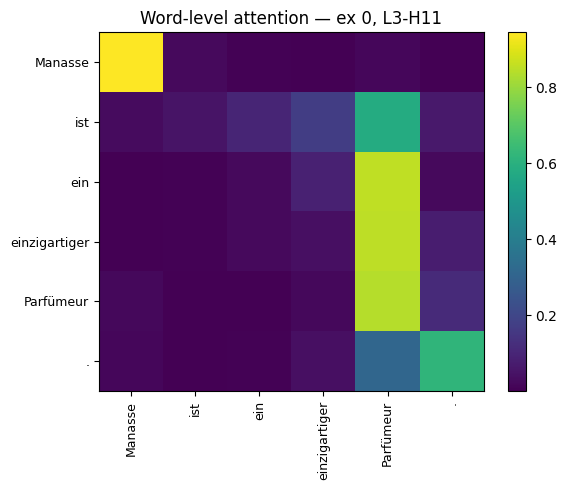

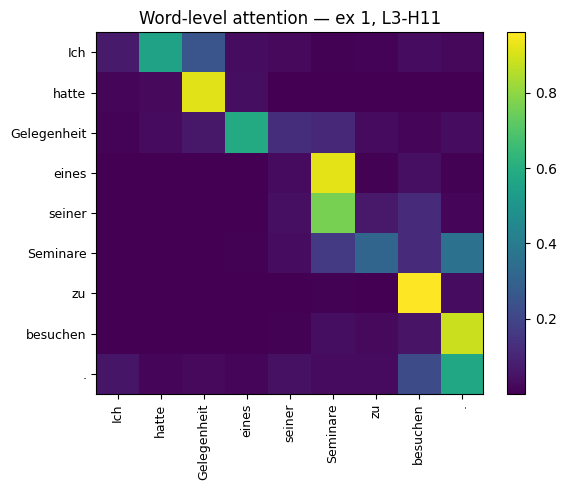

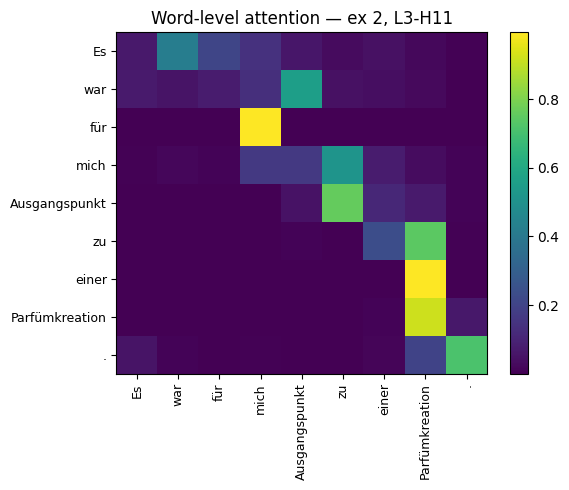

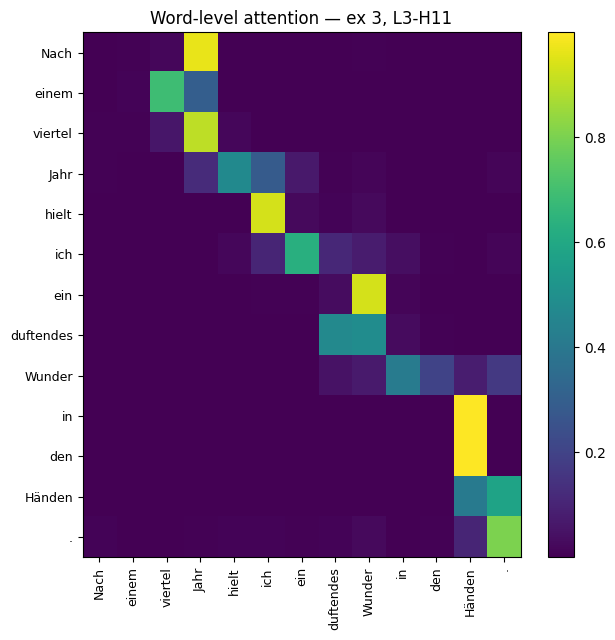

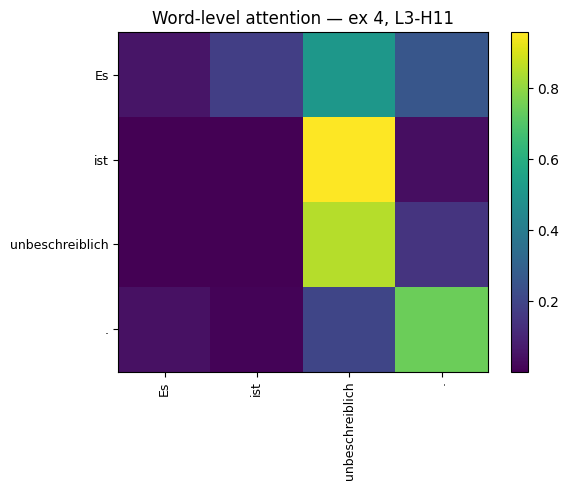

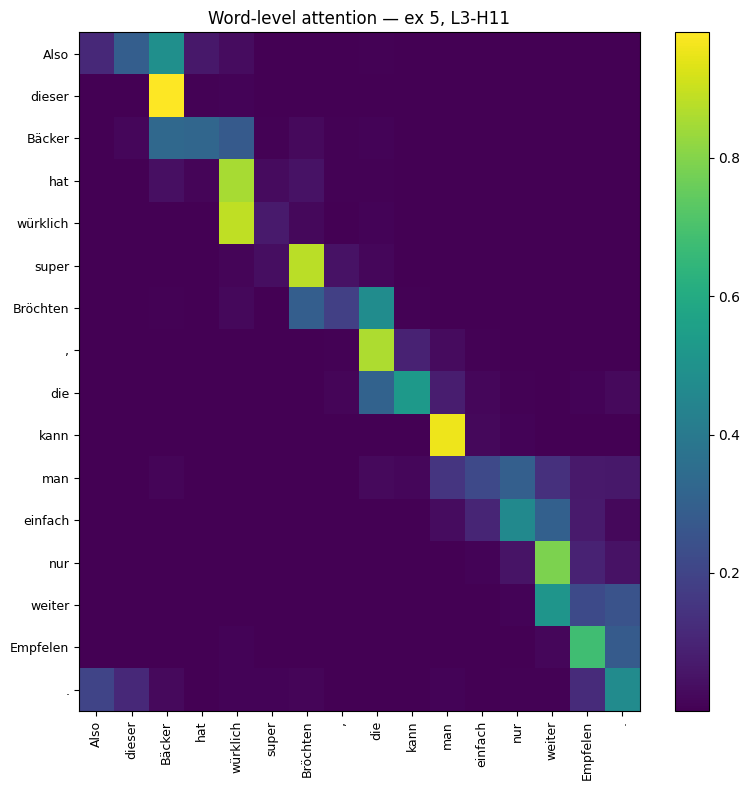

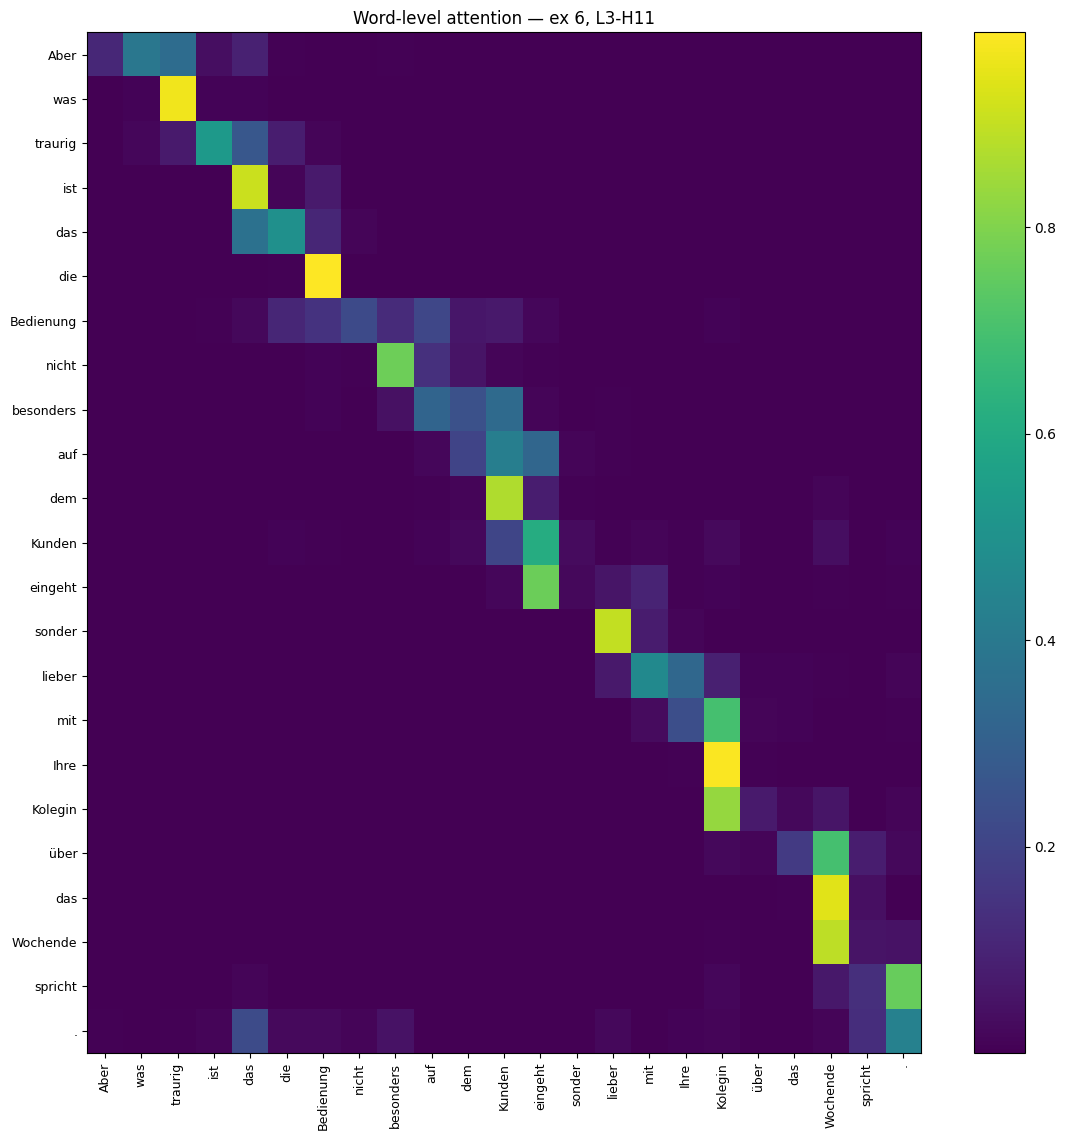

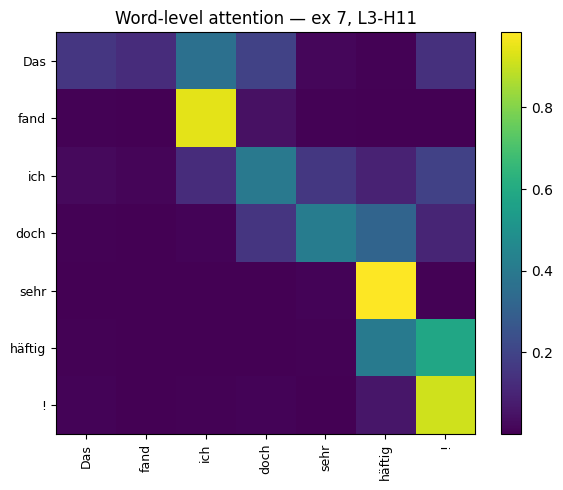

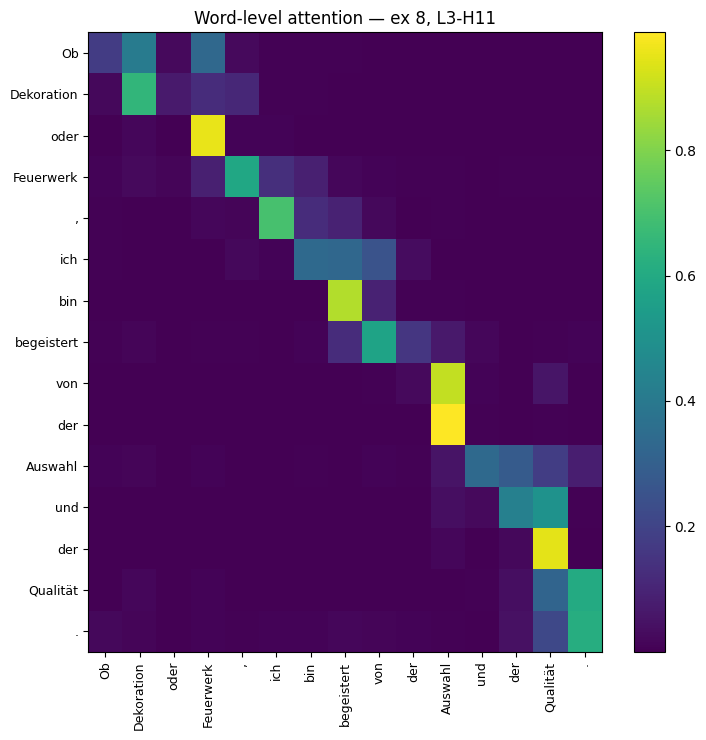

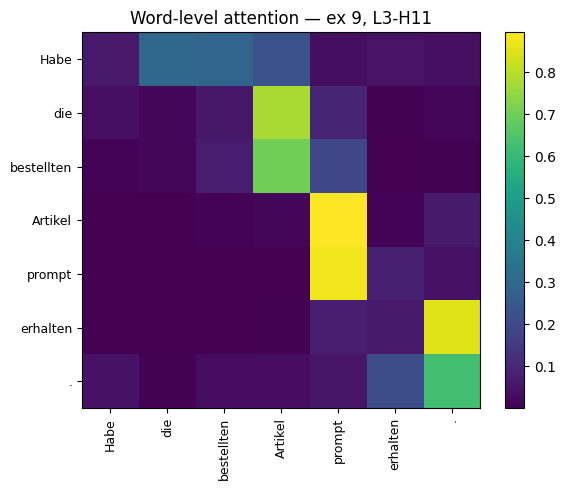

In [71]:
for i in range(10):
    # Use this to PLOT a word-level heatmap for any example/layer/head
    ex_i, layer, head = i, 3, 11
    data = pickle.load(open(ATTN_PKL, "rb"))

    ex = data[ex_i]
    A_TT = ex["attns"][layer, head]
    words = ex.get("words")  # from ud_loader.py
    if not words:
        raise ValueError("This pickle has no UD words. Use ud_loader + extract_attn OR run pool_wordlevel.py.")

    tok = AutoTokenizer.from_pretrained("rifel_multilabel")
    w2s = build_word_to_subword_from_words(tok, words)
    A_WW = pool_TT_to_WW(A_TT, w2s)

    plt.figure(figsize=(max(6, len(words)*0.5), max(5, len(words)*0.5)))
    im = plt.imshow(A_WW, aspect="auto")
    plt.colorbar(im)
    plt.xticks(range(len(words)), words, rotation=90, fontsize=9)
    plt.yticks(range(len(words)), words, fontsize=9)
    plt.title(f"Word-level attention — ex {ex_i}, L{layer}-H{head}")
    plt.tight_layout()
    plt.show()

## 5) Compare acc_top1 vs acc_topk@3

Mean(acc_top1) = 0.142, Mean(acc_topk@3) = 0.399, Mean(diff) = 0.258


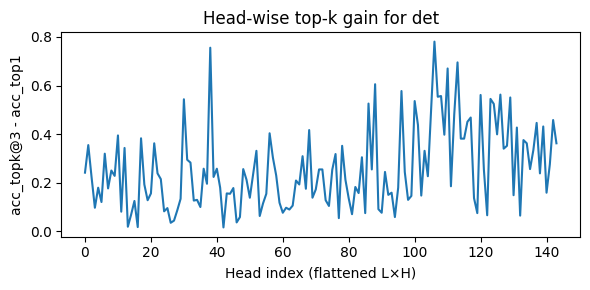

In [68]:

if "acc_topk@3" in rel_res["relations"][REL]:
    acc_topk = np.array(rel_res["relations"][REL]["acc_topk@3"])
    a = acc.flatten()
    k = acc_topk.flatten()
    # Simple scatter-like diagnostic: print summary stats and show a line plot of differences
    diffs = k - a
    print(f"Mean(acc_top1) = {a.mean():.3f}, Mean(acc_topk@3) = {k.mean():.3f}, Mean(diff) = {diffs.mean():.3f}")
    
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(len(diffs)), diffs)
    plt.xlabel("Head index (flattened L×H)")
    plt.ylabel("acc_topk@3 - acc_top1")
    plt.title(f"Head-wise top-k gain for {REL}")
    plt.tight_layout()
    plt.show()
else:
    print("acc_topk@3 not present in results.")



## Notes
- Strong heads should beat both baselines comfortably (especially previous-token).
- If `acc_topk@3` is much larger than `acc_top1`, the head often includes the gold head in the top few targets but not always at rank 1 — still useful, but less “sharp.”
- Check other relations (`REL = "nsubj"`, `"obj"`, etc.) to discover different specialized heads.
